# Ammonia sorption equilibria on Pt-(111)
This jupyter notebook gives an annotated example of the NH$_3$ @ Pt-(111) example in the main manuscript. 

## Plotting Settings

In [31]:
import matplotlib as mpl

mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['figure.dpi'] = 600

%matplotlib inline


# 0) Define the potential energy surface
Before we do any simulation, we have to define how our atoms will interact with eachother. We define the potential energy surface in ASE using a "Calculator". Over [30 calculators are natively implemented in ASE](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html#supported-calculators). Also, external calculators can be designed to work with ASE as is the case with many machine-learned interatomic potentials. Here, we will use the [MACE-MP0 foundational model](https://github.com/ACEsuit/mace):


In [13]:
from mace.calculators import mace_mp
calc = mace_mp()


Using Materials Project MACE for MACECalculator with /Users/Woody/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


## 1) Build the system

This can be done with any of the tools in ASE or with an external code. ASE operates on Atoms objects, so we need to build one of these for our simulation. Because we want to simulate ammonia sorption equilibria on a surface, we need to define ammonia and the platinum surface, let's do that now:

In [14]:
from ase import build
from ase.visualize import view

probe = build.molecule("NH3")
view(probe, viewer = "x3d")

In [15]:
slab = build.fcc111("Pt", (4,4,6), a=3.97, vacuum=15.0, orthogonal=True, periodic=True)
view(slab, viewer = "x3d")

In general, it is good practice to optimize your slab and adsorbate before you do any simulations with them. For GCMC simulations in ASE-MC, we have to do this to obtain the ground state energy of the molecules to be inserted and deleted.

### NH3 Geometry Optimization

In [16]:
from ase.optimize.lbfgs import LBFGS

probe.calc = calc
opt = LBFGS(probe)
opt.run(fmax=0.05)

print("Ground State energy of isolated molecule is:", probe.get_potential_energy())

       Step     Time          Energy          fmax
LBFGS:    0 10:57:46      -19.509018         0.080324
LBFGS:    1 10:57:46      -19.509218         0.017748
Ground State energy of isolated molecule is: -19.509218215942383


### EoS Fitting to find material lattice constants

227.74 GPa
a = 3.97 Å


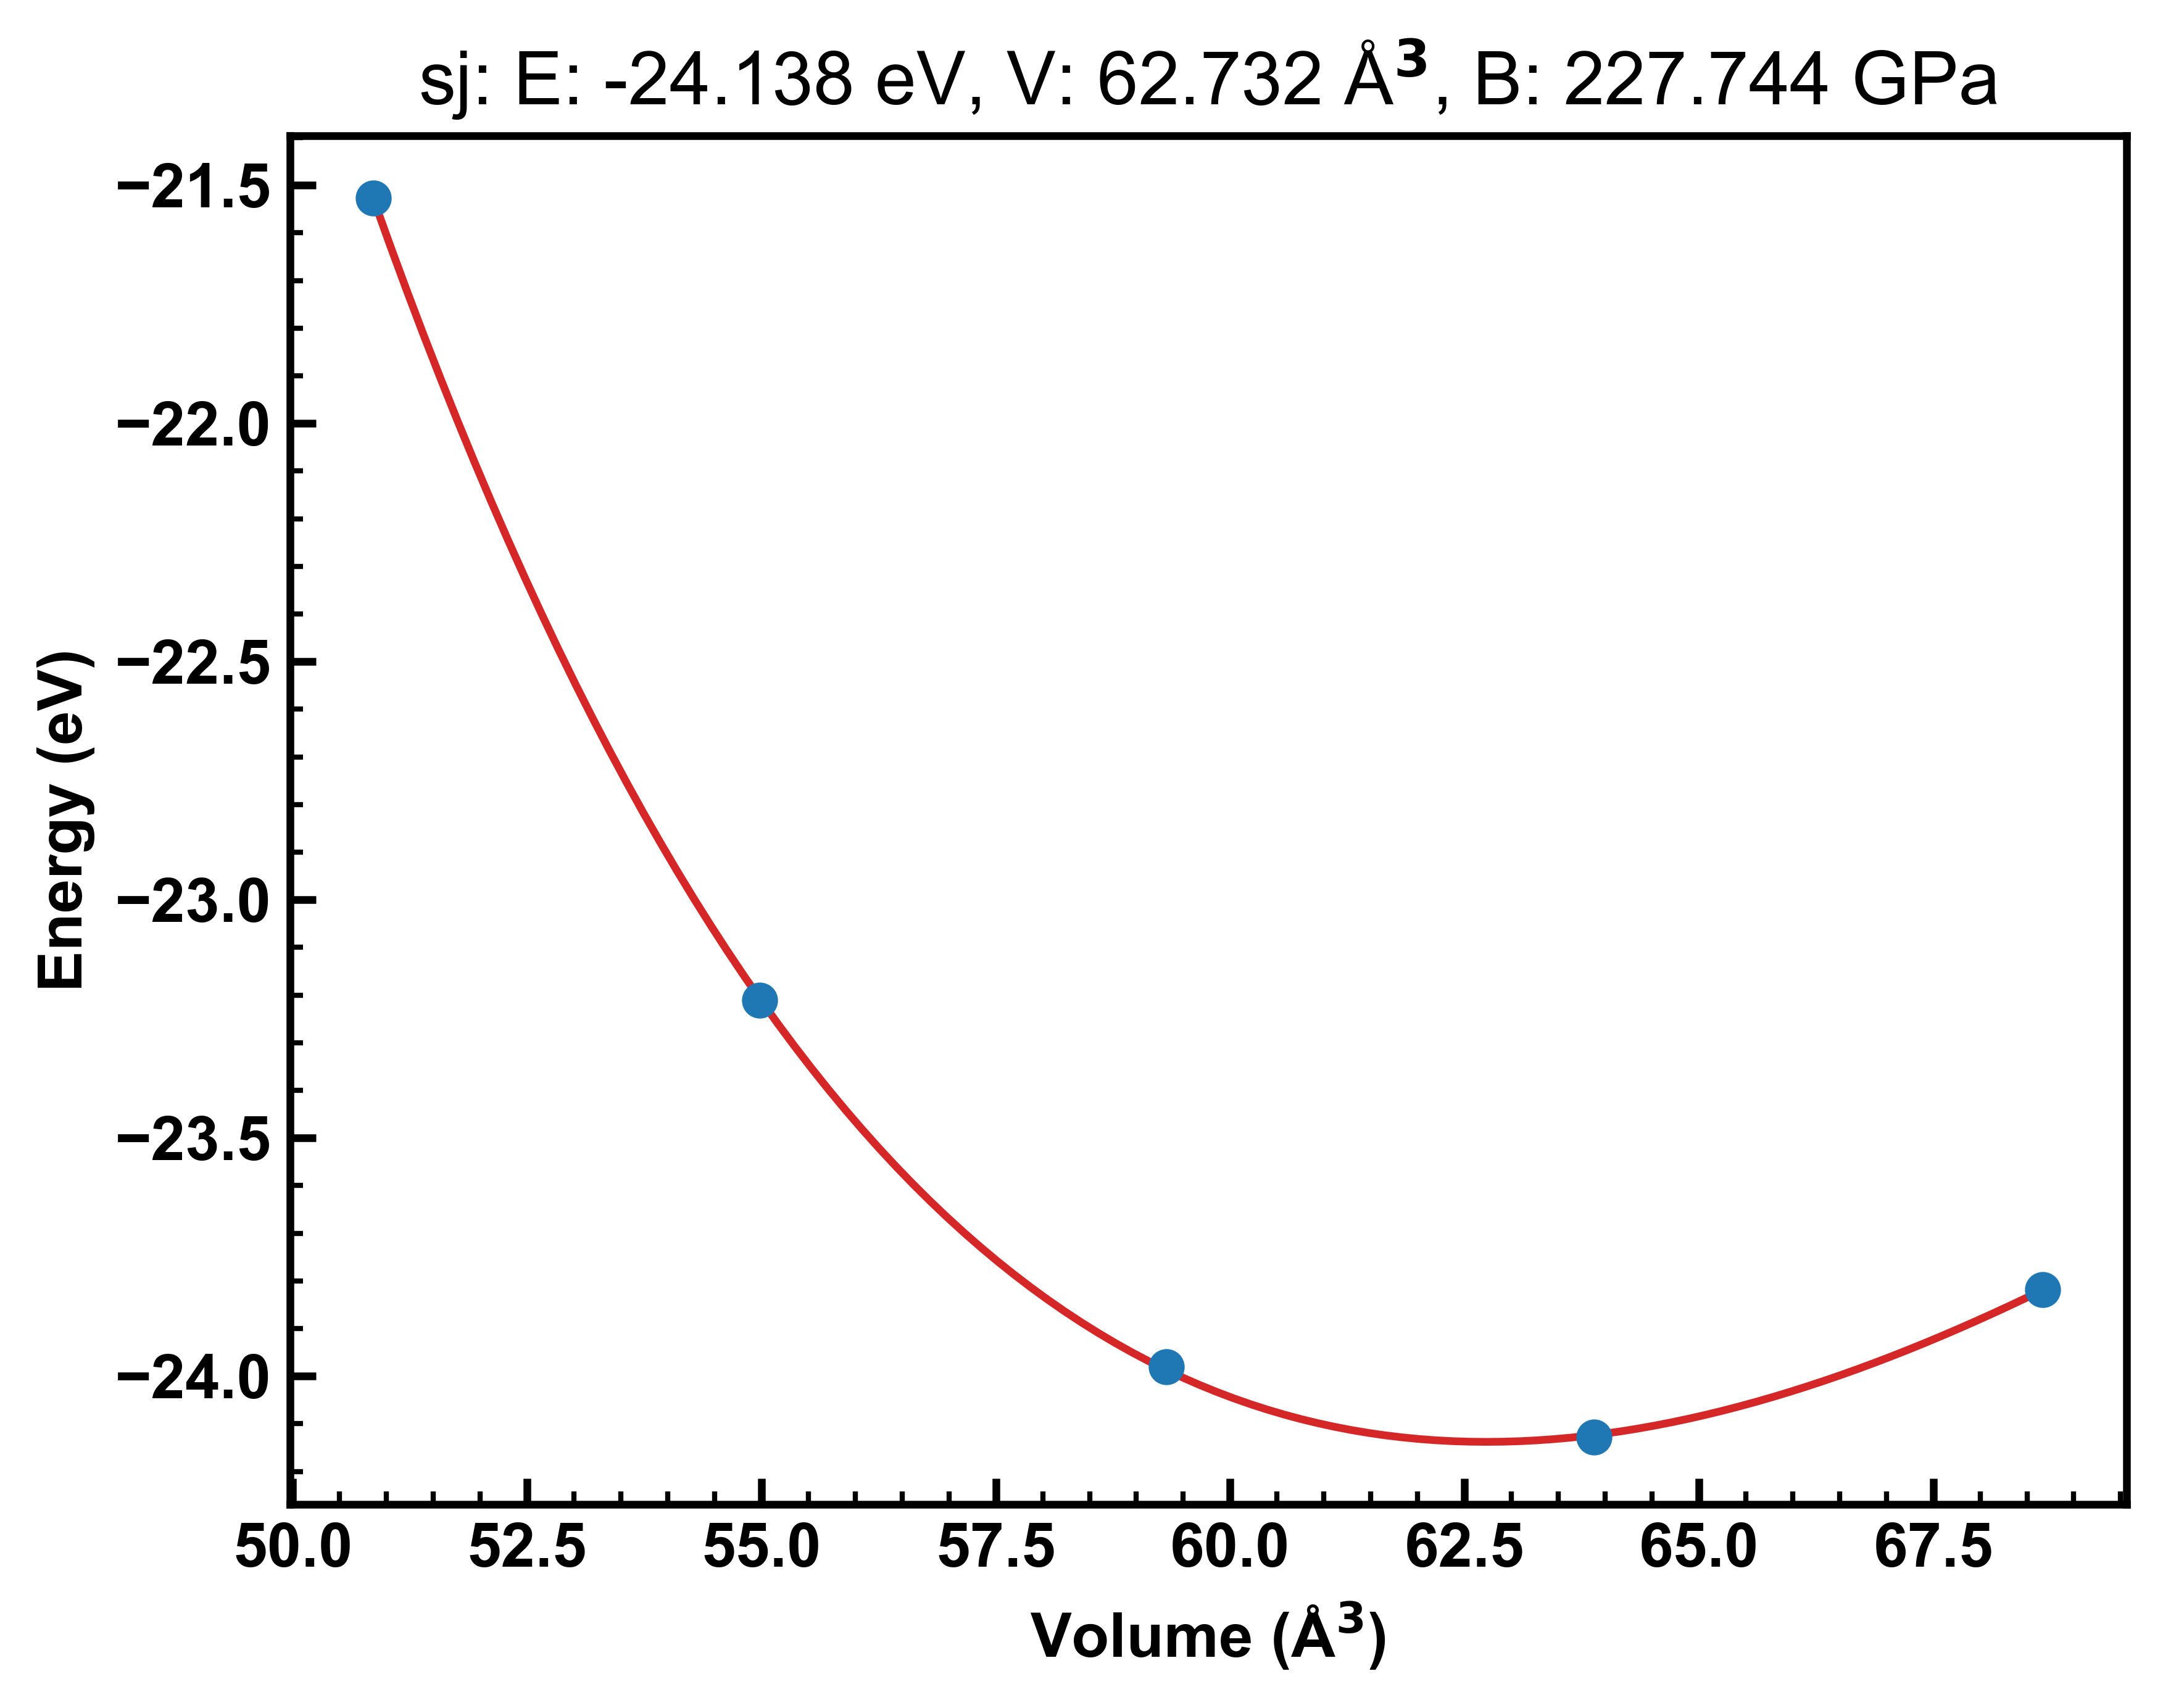

In [32]:
import numpy as np
from ase import units
from ase.eos import EquationOfState

volumes = []
energies = []

atoms = build.bulk("Pt", 'fcc', a=3.9, cubic=True)
atoms.calc = calc
cell = atoms.get_cell()
for x in np.linspace(0.95, 1.05, 5):
    atoms.set_cell(cell * x, scale_atoms=True)
    volumes.append(atoms.get_volume())
    energies.append(atoms.get_potential_energy())


eos = EquationOfState(volumes, energies)

v0, e0, B = eos.fit()
a = v0**(1./3.)
print(f"{B / units.kJ * 1.0e24:.2f} GPa")
print(f"a = {a:.2f} Å")

eos.plot()
pass

## 2) Set Up Monte Carlo Moves
At this point, everything we have done so far can already be done natively in ASE with MACE-MP0. Now, we start using the Monte Carlo library. The next step in this workflow is to define what moves will be included in the Monte Carlo simulation. Ensemble objects provide the user a set of moves to sample a given ensemble, and Moveset can be used to adjust move parameters.


In [18]:
from ase.mc import BVT, Moveset, MonteCarlo

atoms = build.fcc111("Pt", (4,4,6), a=a, vacuum=15.0, orthogonal=True, periodic=True)

ensemble = BVT(
    temperature_K= 1000.0,                            # Temperature of the simulation in K
    b_parameter = [3.0],                              # Dimensionless chemical potential of each species (order matters!)
    species = [probe],                                # Species to be inserted and deleted (order maters!)
    reference_energy=[probe.get_potential_energy()],  # Reference energy of an isolated molecule (order matters!)
    rcavity = 2.5,                                    # Cavity radius used to serch for atoms and define grid points as cavities
    grid_resolution=20,                               # The number of grid points along the lattice vectors used to search for cavities
    cavity_bias=True,                                 # Metropolis sampling of insertions and deletions (False) or apply cavity bias (True)
    starting_tag = 7,                                 # The integer assigned to atom.tag for logging the species inserted and deleted.
                                                      # We start at 7 because build.fcc111 includes tags to identify slab layers
    exclusion_list = np.arange(len(atoms))            # We do not want to attempt any thermal moves on the slab asside from HMC  
)

moveset = Moveset(ensemble.get_moves())
moveset.adjust_parameter("Translate", "max_delta", 5.0)


## 3) Run the Simulation
With the moveset, we are finally ready to start the Monte Carlo simulation! Here, we only run for a couple of steps to demonstrate the library, but for production simulations you should run longer. 


In [19]:
dyn = MonteCarlo(
    atoms,
    dft_calc=calc,
    moveset=moveset,
    trajectory = "gcmc.traj",
    logfile = "gcmc.log",
    loginterval=1,
)

dyn.run(100)

True

## 4) Analyze the simulation
Congrats, you have just ran a Monte Carlo GCMC simulation with a MLIP! The logfile contains information about the sucessrate of moves over the course of the simulation, and the trajectory is an ASE Trajectory object that can be analyzed with tools in ASE.


In [20]:
!ls

ASE-MC_Workflow.ipynb gcmc.traj             lbfgs.traj
gcmc.log              lbfgs.log             species_7.xyz


In [21]:
!head gcmc.log

MC Step     Time     Epot[eV]     Move Statistics
0      10:58:19   -561.98962         Initializing
1      10:58:28   -561.52747             move:HMC          accepted:1         attempted:1         dt_fs:1.000                    
2      10:58:29   -581.03668          move:Insert          accepted:1         attempted:1       species_tag:7         n_species:1    n_cavities: 5200
3      10:58:38   -580.55005             move:HMC          accepted:2         attempted:2         dt_fs:1.000                    
4      10:58:39   -580.55005          move:Delete          accepted:0         attempted:1       species_tag:7         n_species:1    n_cavities: 5199
5      10:58:41   -600.06177          move:Insert          accepted:2         attempted:2       species_tag:7         n_species:2    n_cavities: 4978
6      10:58:42   -619.58087          move:Insert          accepted:3         attempted:3       species_tag:7         n_species:3    n_cavities: 4761
7      10:58:43   -619.58087       move:

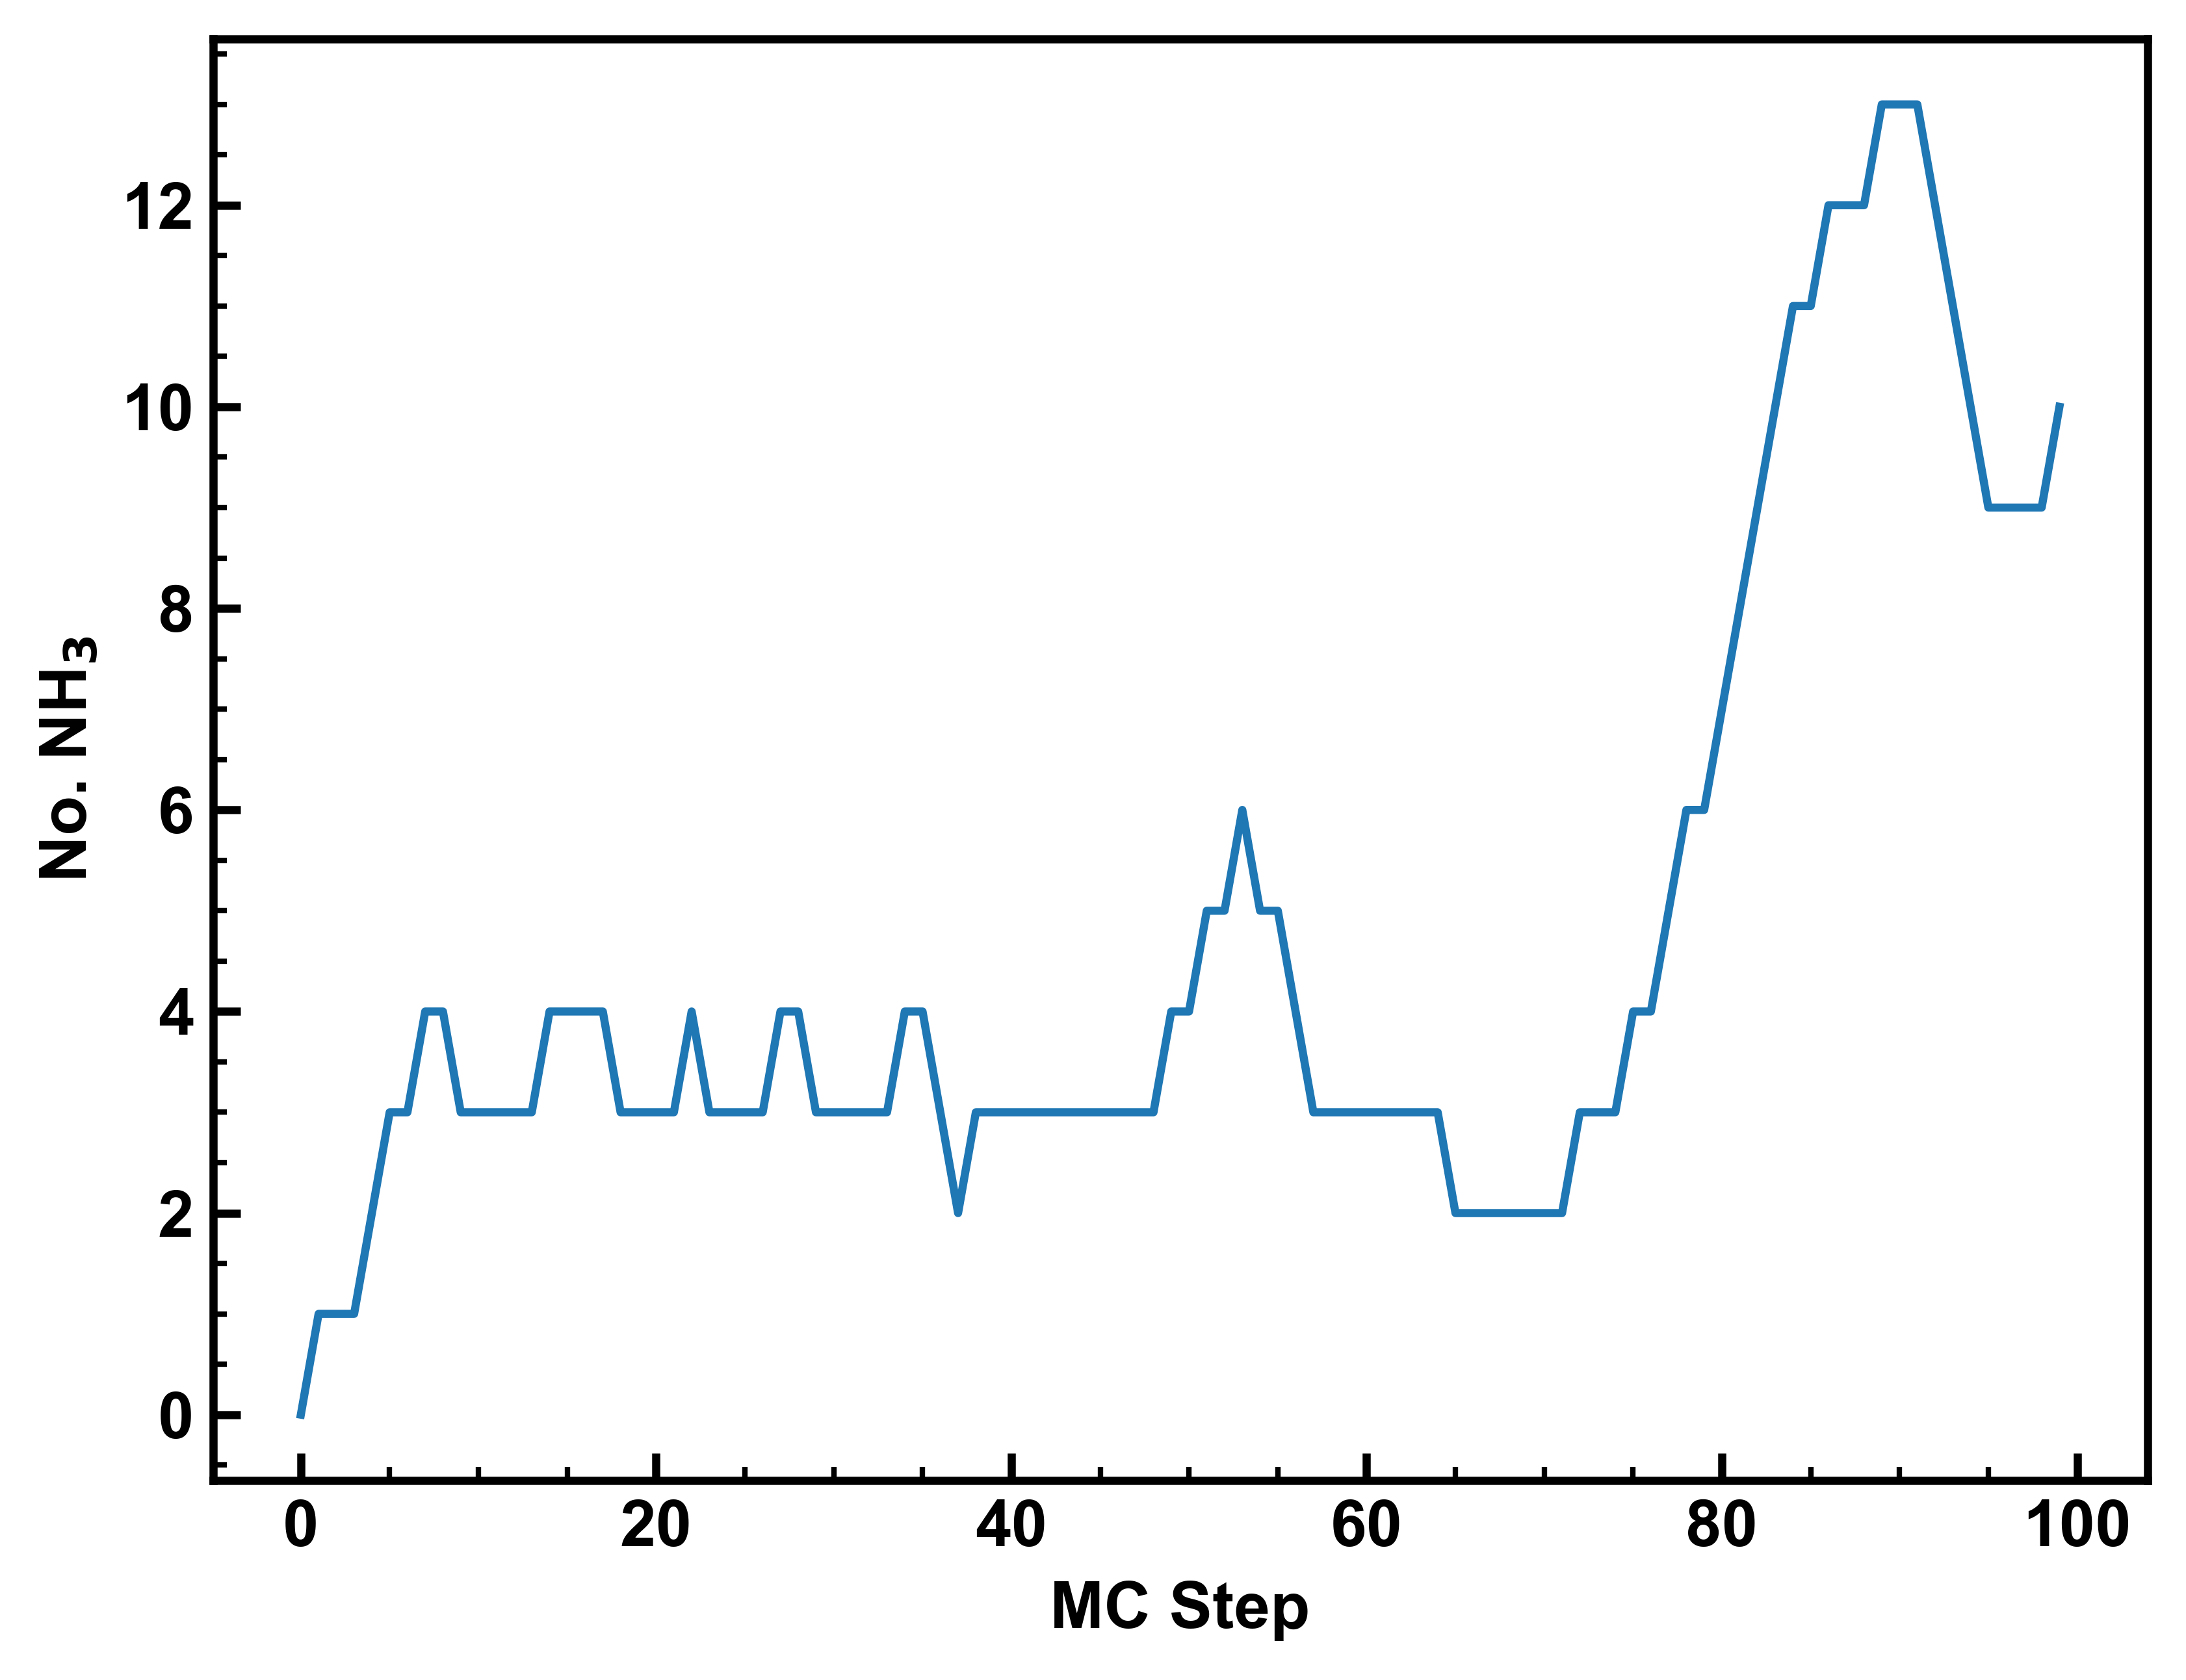

In [33]:
from ase.io.trajectory import Trajectory
import matplotlib.pyplot as plt

traj = Trajectory("gcmc.traj")
nframes = len(traj)

# Plot the number of NH3 molecules over the course of the simulation
# Loop over all frames and count the number of N atoms in each frame
frame = 0
nmols = np.zeros(nframes)
for atoms in traj:
    nmols[frame] = len([atom.index for atom in atoms if atom.symbol=='N'])
    frame += 1

plt.plot(nmols)
plt.xlabel("MC Step")
plt.ylabel("No. NH$_3$")
plt.show()